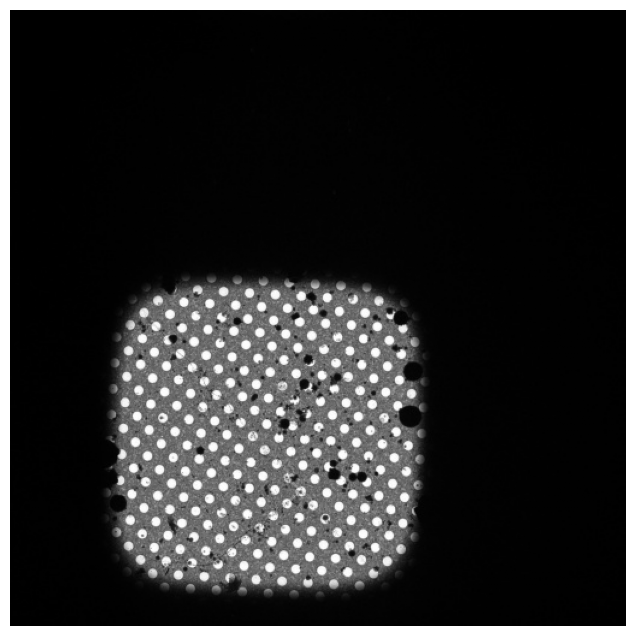

In [53]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

img = cv2.imread("GridSquare_20241015_171302.jpg", cv2.IMREAD_GRAYSCALE)
img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)

def display_image(image, points=None):
    plt.figure(figsize=(8, 8))
    plt.imshow(image, cmap='gray')

    colors = 'grbcmyk'
    
    if points is not None:
        
        if isinstance(points[0], list) or isinstance(points[0], np.ndarray):
            for idx, point_set in enumerate(points):
                color = colors[idx % len(colors)]
                for point in point_set:
                    plt.plot(point[0], point[1], color + 'o')  # Plot points in different colors
        else:
            for point in points:
                plt.plot(point[0], point[1], 'ro')  # Plot points in red

    plt.axis('off')  # Hide axis

display_image(img)

In [54]:
import cv2
import mrcfile
import numpy as np

# Read the JPG image
img = cv2.imread("GridSquare_20241015_171302.jpg", cv2.IMREAD_GRAYSCALE)

# Normalize the image to appropriate range (optional)
img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)

# Convert to float32 (MRC files typically use float32)
img_float = img.astype(np.float32)

# Write to MRC file
with mrcfile.new('GridSquare_20241015_171302.mrc', overwrite=True) as mrc:
    mrc.set_data(img_float)
    
    # Optional: Set pixel size (in Angstroms per pixel)
    mrc.voxel_size = (1.0, 1.0, 1.0)  # Adjust as needed
    
    # Optional: Set origin
    mrc.header.origin.x = 0.0
    mrc.header.origin.y = 0.0
    mrc.header.origin.z = 0.0

print("JPG converted to MRC successfully!")


JPG converted to MRC successfully!


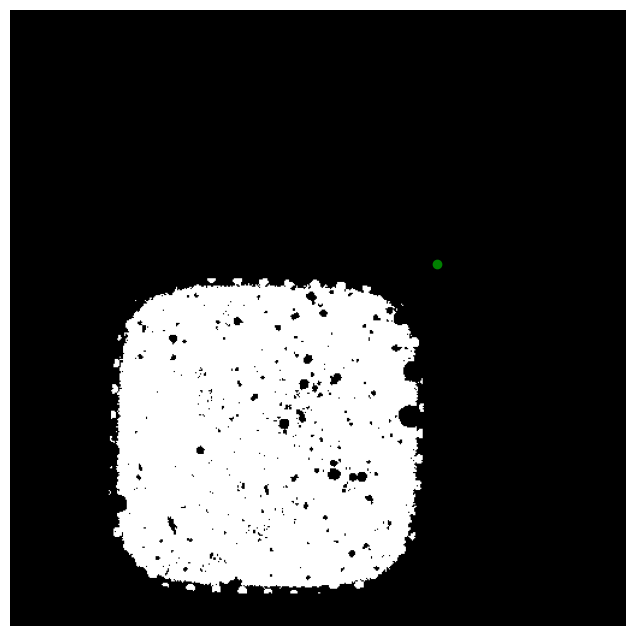

In [55]:
img_bin = cv2.resize(img, (0,0), fx=1, fy=1, interpolation=cv2.INTER_NEAREST)

img_t, thresh = cv2.threshold(img_bin, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# thresh = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)

centroid = np.mean(np.argwhere(thresh == 255), axis=0).astype(int)

display_image(thresh, points=[[centroid]])

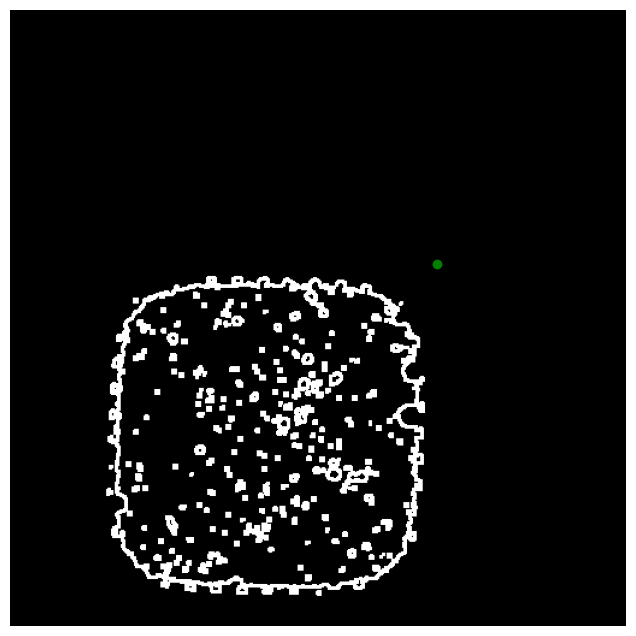

In [56]:
edges = cv2.Canny(thresh, 100, 200)

edges = cv2.dilate(edges, None)

display_image(edges, points=[[centroid]])

Number of labels: 157


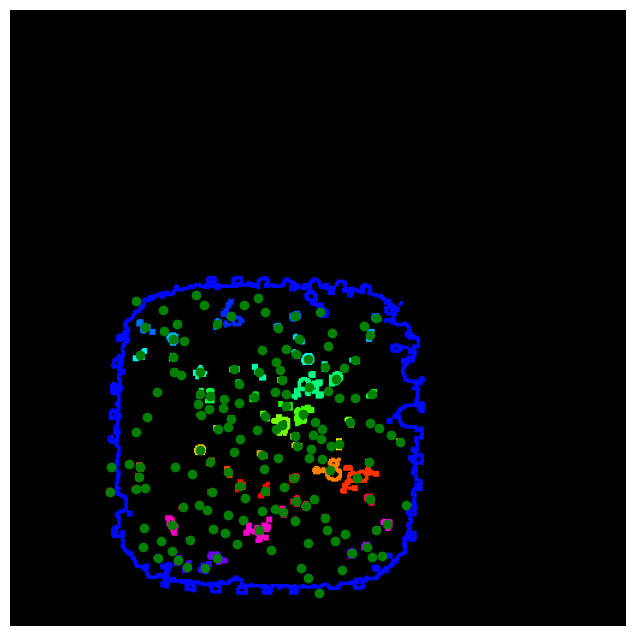

In [57]:
n_labels, edges_labeled, stats, centroids = cv2.connectedComponentsWithStats(edges)

print(f"Number of labels: {n_labels}")

label_hue = np.uint8(179*edges_labeled/np.max(edges_labeled))
blank_ch = 255*np.ones_like(label_hue)
labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

labeled_img[label_hue==0] = 0

display_image(labeled_img, points=[centroids])

Found 360 contours


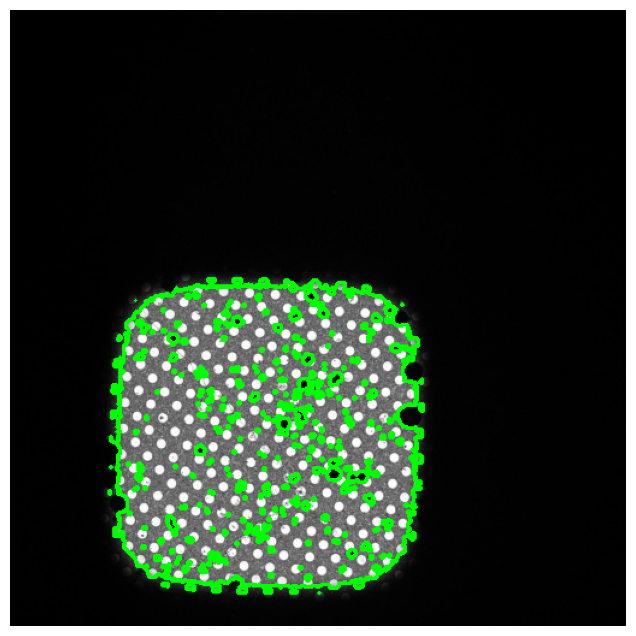

In [58]:
# Find contours to create regions for containment analysis
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

print(f"Found {len(contours)} contours")

# Visualize all contours
img_contours = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
cv2.drawContours(img_contours, contours, -1, (0, 255, 0), 2)

display_image(img_contours)

Found 35 contours


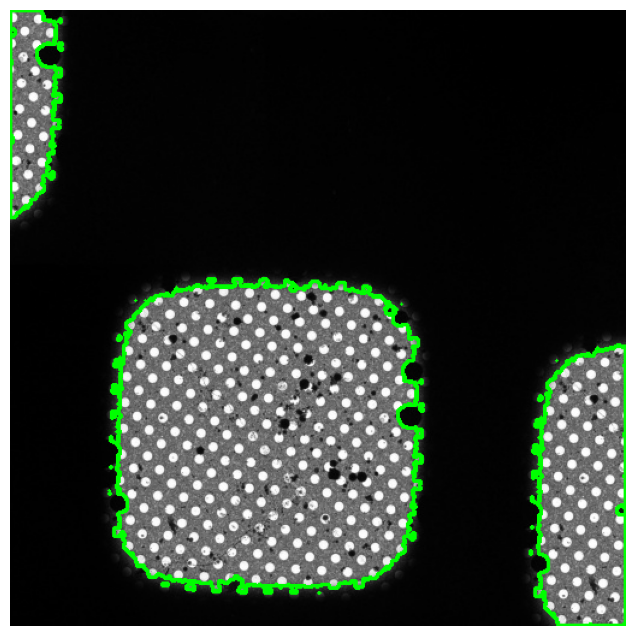

In [59]:
def translate_img(thresh, offset):
    M = np.float32([[1, 0, offset[0]], [0, 1, offset[1]]])
    shifted = cv2.warpAffine(thresh, M, (thresh.shape[1], thresh.shape[0]))
    return shifted

img_t1 = translate_img(img, (350, 50))
img_t2 = translate_img(img, (-300, -300))
img_t3 = translate_img(img, (0, 0))


img_t12 = cv2.addWeighted(img_t1, 1, img_t2, 1, 0)
img_t12 = cv2.addWeighted(img_t12, 1, img_t3, 1, 0)


img_t12_filt = cv2.blur(img_t12, (5, 5))

imgl, thresh_t_filt = cv2.threshold(img_t12, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)


# Find contours to create regions for containment analysis
contours, hierarchy = cv2.findContours(thresh_t_filt, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

print(f"Found {len(contours)} contours")

# Visualize all contours
img_contours = cv2.cvtColor(img_t12, cv2.COLOR_GRAY2BGR)
cv2.drawContours(img_contours, contours, -1, (0, 255, 0), 2)

display_image(img_contours)

In [60]:
import cv2
import mrcfile
import numpy as np

# Read the JPG image
img = img_t12

# Normalize the image to appropriate range (optional)
img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)

# Convert to float32 (MRC files typically use float32)
img_float = img.astype(np.float32)

# Write to MRC file
with mrcfile.new('GridSquare_20241015_171302.mrc', overwrite=True) as mrc:
    mrc.set_data(img_float)
    
    # Optional: Set pixel size (in Angstroms per pixel)
    mrc.voxel_size = (1.0, 1.0, 1.0)  # Adjust as needed
    
    # Optional: Set origin
    mrc.header.origin.x = 0.0
    mrc.header.origin.y = 0.0
    mrc.header.origin.z = 0.0

print("JPG converted to MRC successfully!")

JPG converted to MRC successfully!


In [61]:
def border_contour(contour, img) -> bool:
    x, y, w, h = cv2.boundingRect(contour)
    if x <= 1 or y <= 1 or (x + w) >= (img.shape[1] - 1) or (y + h) >= (img.shape[0] - 1):
        return True
    return False

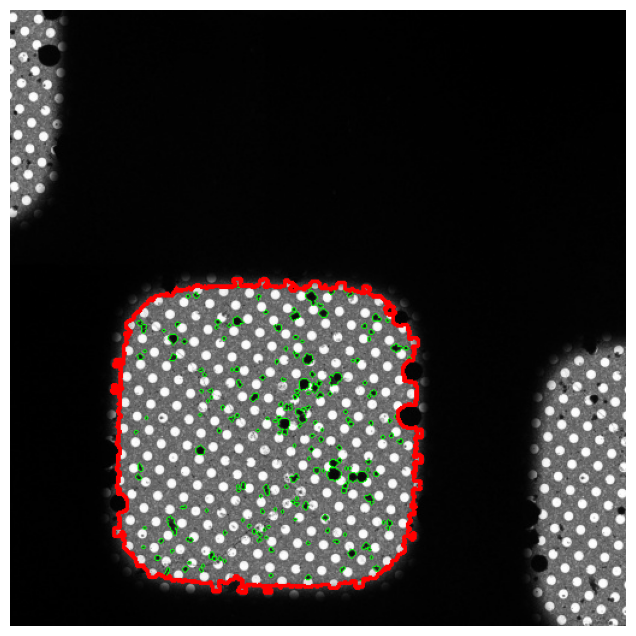

In [62]:
# Visualize all contours

valid_contours = []
for c, h in zip(contours, hierarchy[0]):
    if cv2.contourArea(c) < 400:
        continue
    elif border_contour(c, img_t12):
        continue
    else:
        valid_contours.append(c)

inner_contours = []
for c in valid_contours:
    mask = np.zeros(img_t12.shape, dtype=np.uint8)
    cv2.drawContours(mask, [c], -1, 255, thickness=cv2.FILLED)  # Fill the contour
    masked_img = cv2.bitwise_and(img_t12, img_t12, mask=mask)
    
    masked_img = cv2.threshold(masked_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    contours, hierarchy = cv2.findContours(masked_img, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)

    for j, (ic, ih) in enumerate(zip(contours, hierarchy[0])):
        if ih[3] != -1 and cv2.contourArea(ic) > 2:
            inner_contours.append(ic)
            
    

draw_contours = cv2.cvtColor(img_t12, cv2.COLOR_GRAY2BGR)
cv2.drawContours(draw_contours, inner_contours, -1, (0, 255, 0), thickness=1)
cv2.drawContours(draw_contours, valid_contours, -1, (255, 0, 0), thickness=2)

display_image(draw_contours)    

In [63]:
import imodmodel
from imodmodel.models import ContourType
import pandas as pd

df_d = {
    "object_id": [],
    "contour_id": [],
    "x": [],
    "y": [],
    "z": [],
}

for i, vc in enumerate(valid_contours):
    
    first_point = vc[0][0]
    
    for point in vc:
        x, y = point[0]
        df_d["x"].append(x)
        df_d["y"].append(y)
        df_d["z"].append(0)
        df_d["object_id"].append(0)
        df_d["contour_id"].append(i)
        
        
df = pd.DataFrame(df_d)

imodmodel.write(df, "grid_square_test.mod", type=ContourType.CLOSED)

In [64]:
%%bash

ls /usr/local/IMOD/bin/imodholefinder

imodholefinder -input GridSquare_20241015_171302.mrc \
        -output holes.mod \
        -boundary "grid_square_test.mod" \
        -summary holes_summary.txt \
        -diameter -8 \
        -spacing -18 \
                
# 3dmod GridSquare_20241015_171302.mrc holes.mod

ls: /usr/local/IMOD/bin/imodholefinder: No such file or directory


best: sigma 2.0  threshold 4.4  found  194  missing  30
iz =   0  diam 7.85  spacing 15.27  found 194  missing 30 (1 close)


/var/folders/qm/73mpkrb57_xdjr7t2yz9q8l00000gn/T/ipykernel_74780/3746590546.py:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  summary = pd.read_csv("holes_summary.txt", delim_whitespace=True, header=0, names=['x', 'y', 'z', '0', 'corr', 'std', 'neg_smooth', 'i', 'j'], index_col=False);


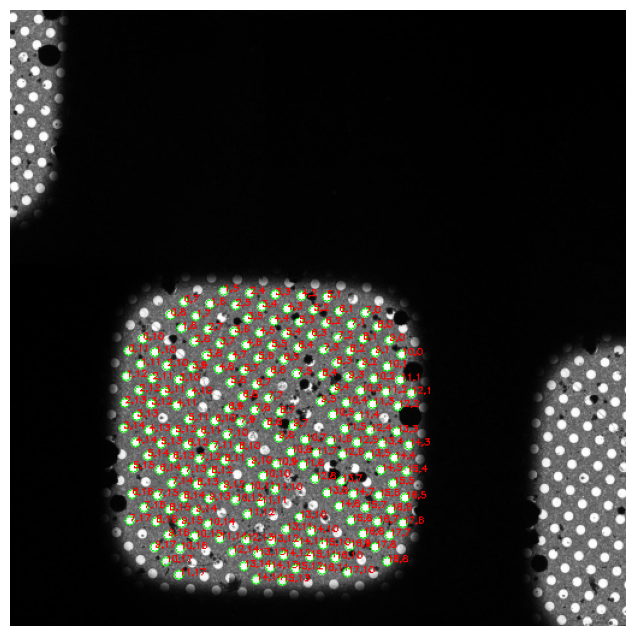

In [65]:
import imodmodel

results = imodmodel.read("holes.mod")

img = img_t12.copy()

img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

summary = pd.read_csv("holes_summary.txt", delim_whitespace=True, header=0, names=['x', 'y', 'z', '0', 'corr', 'std', 'neg_smooth', 'i', 'j'], index_col=False);

for x,y,i,j in zip(summary['x'], summary['y'], summary['i'], summary['j']):
    x = int(x)
    y = int(y)
    cv2.circle(img, center=(x, y), radius=4, color=(0, 255, 0), thickness=1)
    cv2.putText(img, f'{i},{j}', (x, y), cv2.FONT_HERSHEY_SCRIPT_SIMPLEX, 0.25, (255, 0, 0), 1)
    
cv2.resize(img, (0,0), fx=2, fy=2, interpolation=cv2.INTER_NEAREST)
cv2.imwrite("holes_detected.png", img)
display_image(img)


In [66]:
shapex = int(summary["i"].max()) + 1
shapey = int(summary["j"].max()) + 1

detected_hole_indices = list(zip(summary["i"], summary["j"]))

arr = np.zeros((shapex, shapey), dtype=int)

for i, j in detected_hole_indices:
    arr[i, j] = 1

In [67]:
from scipy.ndimage import generic_filter
from math import prod

def get_coords_at_index(summary: pd.DataFrame, index):
    row = summary[(summary['i'] == index[0]) & (summary['j'] == index[1])]
    if not row.empty:
        return row['x'].values[0], row['y'].values[0]
    else:
        return None
    
def find_axes_angle(summary: pd.DataFrame):  
    # Make array of detected holes
    shapex = int(summary["i"].max()) + 1
    shapey = int(summary["j"].max()) + 1

    detected_hole_indices = list(zip(summary["i"], summary["j"]))

    arr = np.zeros((shapex, shapey), dtype=int)

    for i, j in detected_hole_indices:
        arr[i, j] = 1  
        
    # Find locations where there are neighbors along grid x axes (for calculating normal vector and angle)
    filt = np.array([[0, 0, 0], 
                     [1, 1, 1], 
                     [0, 0, 0]])
    arr_filt = generic_filter(arr, prod, footprint=filt, mode='constant', cval=0)

    index = np.argwhere(arr_filt == 1)
    
    vec_list = []
    for idx in index:
        coord1 = get_coords_at_index(summary, (idx[0], idx[1]+1))
        coord2 = get_coords_at_index(summary, (idx[0], idx[1]-1))
        vec = np.array(coord1) - np.array(coord2)
        vec_list.append(vec)
    vec = np.mean(np.array(vec_list), axis=0)
    
    ref_vec = np.array([0, 2])
    spacing = np.linalg.norm(vec) / 2
    
    unit_vec = vec / spacing
    
    angle = np.arctan2(unit_vec[1], unit_vec[0]) - np.arctan2(ref_vec[1], ref_vec[0])
        
    return arr, spacing, angle

def find_hole_array_center(summary: pd.DataFrame):
    x_center = summary['x'].mean()
    y_center = summary['y'].mean()
    return round(x_center), round(y_center)


Detected spacing: 15.32 pixels
Detected angle: 0.85 radians


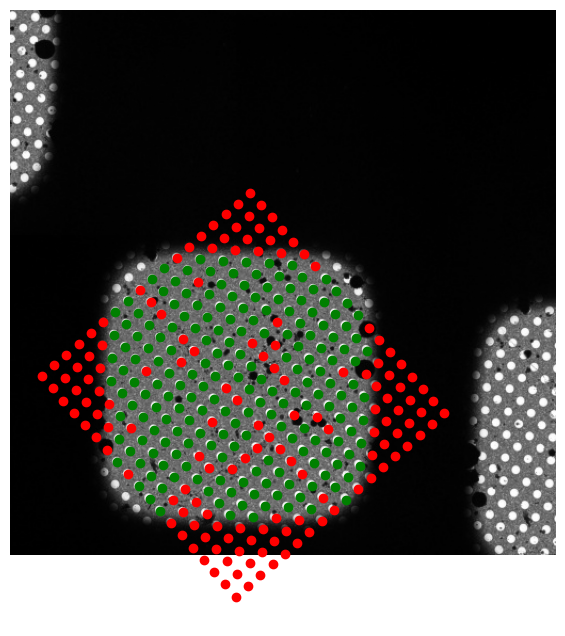

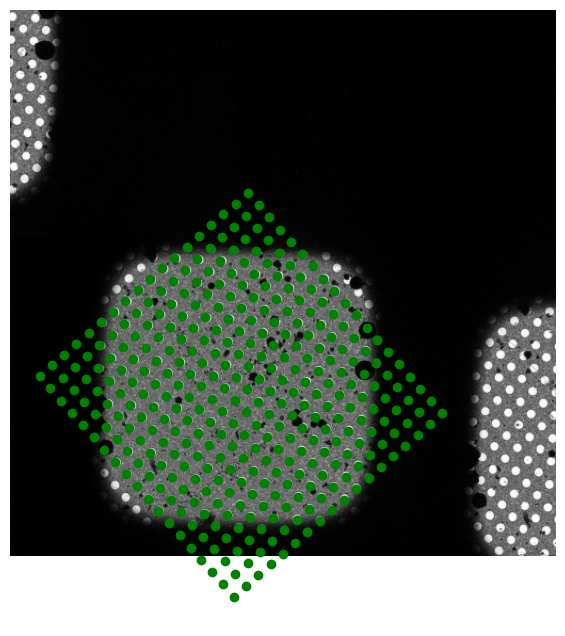

In [68]:
arr, spacing, angle = find_axes_angle(summary)
print(f"Detected spacing: {spacing:.2f} pixels")
print(f"Detected angle: {angle:.2f} radians")

indices = np.argwhere(arr == 1)

ref_idx = indices[0]
ref_pt = get_coords_at_index(summary, (ref_idx[0], ref_idx[1]))
ref_pt = np.array(ref_pt)
# Scale indices to actual coordinates
scaled_indices = (indices - ref_idx) * spacing + ref_pt

center_scaled = np.mean(scaled_indices, axis=0)
center_absolute = find_hole_array_center(summary)
scaled_indices += (center_absolute - center_scaled)

# Calculate center of the points
center = np.mean(scaled_indices, axis=0)

# Create rotation matrix
rot_matrix = np.array([[np.cos(angle), -np.sin(angle)],
                      [np.sin(angle),  np.cos(angle)]])
# Vectorized rotation around center
centered_points = scaled_indices - center
rotated_points = (rot_matrix @ centered_points.T).T
points = rotated_points + center

zero_indices = np.argwhere(arr == 0)
scaled_zero_indices = (zero_indices - ref_idx) * spacing + ref_pt
scaled_zero_indices += (center_absolute - center_scaled)
scaled_zero_indices_centered = scaled_zero_indices - center
rotated_zero_points = (rot_matrix @ scaled_zero_indices_centered.T).T
zero_points = rotated_zero_points + center


display_image(img_t12, points=[points, zero_points])
# plt.scatter(points[:, 1], points[:, 0], color='red')

img_bin = np.zeros(img_t12.shape, dtype=np.uint8)

for point in points:
    x = int(round(point[0]))
    y = int(round(point[1]))
    cv2.circle(img_bin, center=(x, y), radius=1, color=255, thickness=-1)  
    
img_bin = cv2.GaussianBlur(img_bin, (25, 25), sigmaX=3.925, sigmaY=3.925) 

shift, response = cv2.phaseCorrelate(np.float32(img_t12), np.float32(img_bin))

aligned_points = points - shift[::-1]
aligned_zero_points = zero_points - shift[::-1]

all_points = np.vstack([aligned_points, aligned_zero_points])
all_indices = np.vstack([np.argwhere(arr == 1), np.argwhere(arr == 0)])

display_image(img_t12, points=[all_points])


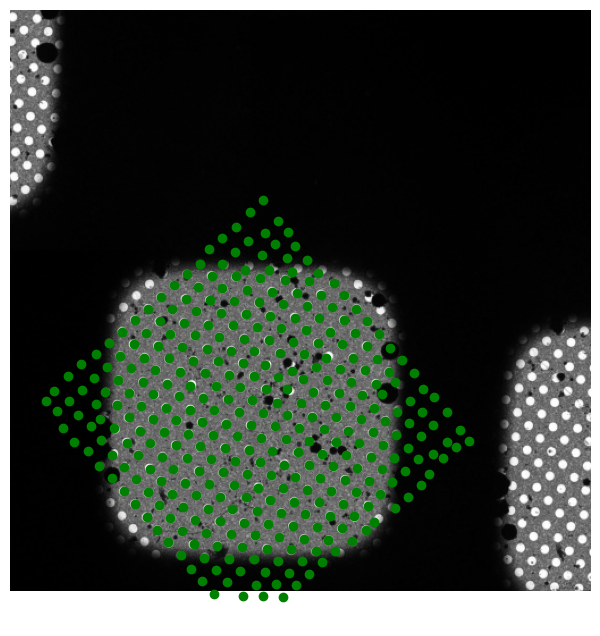

In [69]:
# Optimize aligned points
window_size = 21  # Size of the cropping window
hw = window_size // 2  # Half window size

optimized_points = []
for point in all_points:
    x = int(round(point[0]))
    y = int(round(point[1]))
    
    # Crop image around points
    
    x_start = max(x - hw, 0)
    x_end = min(x + hw, img_t12.shape[1])
    y_start = max(y - hw, 0)
    y_end = min(y + hw, img_t12.shape[0])
    
    crop = img_t12[y_start:y_end, x_start:x_end]
    crop = cv2.normalize(crop, None, 0, 255, cv2.NORM_MINMAX)
    t, thresh = cv2.threshold(crop, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

    if contours:
        #Filter out contours touching border
        min_dist = float('inf')
        for c in contours:
            if border_contour(c, thresh):
                continue
            else:
                current_dist = np.linalg.norm(np.mean(c, axis=0) - np.array([hw, hw]))
            if current_dist > 5:
                continue
            elif current_dist < min_dist:
                min_dist = current_dist
                
                (x,y), radius = cv2.minEnclosingCircle(c)
                shift = (np.array([x, y]) - np.array([hw, hw]))
                best_contour = c
                
        crop = cv2.cvtColor(crop, cv2.COLOR_GRAY2BGR)
        circle_center = (int(hw + shift[0]), int(hw + shift[1]))
        
        optimized_point = point + shift
        optimized_points.append(optimized_point)
        
        cv2.circle(crop, center=circle_center, radius=4, color=(255, 0, 0), thickness=1)
        cv2.drawContours(crop, best_contour, -1, (0, 255, 0), thickness=1) 

display_image(img_t12, points=[optimized_points])

[[0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 0 1 0 0 1 1 1 0 0 0 0 0]
 [0 0 0 1 1 0 0 1 1 1 1 1 1 1 0 0 0 0]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0]
 [0 1 0 0 1 1 1 0 1 0 1 1 1 1 1 1 0 0]
 [0 1 1 1 0 0 1 1 1 0 1 1 1 1 1 0 1 0]
 [1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1]
 [0 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 1]
 [0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1]
 [0 1 1 1 1 1 1 0 1 0 0 0 1 1 1 1 0 1]
 [0 1 1 1 1 1 0 0 1 1 1 1 0 1 1 0 1 0]
 [0 0 0 0 1 0 0 0 1 0 0 1 0 1 1 0 0 0]
 [0 0 0 1 1 0 0 1 1 0 1 1 1 1 1 0 0 0]
 [0 0 0 0 1 1 0 1 1 1 1 1 1 1 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 0 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]]


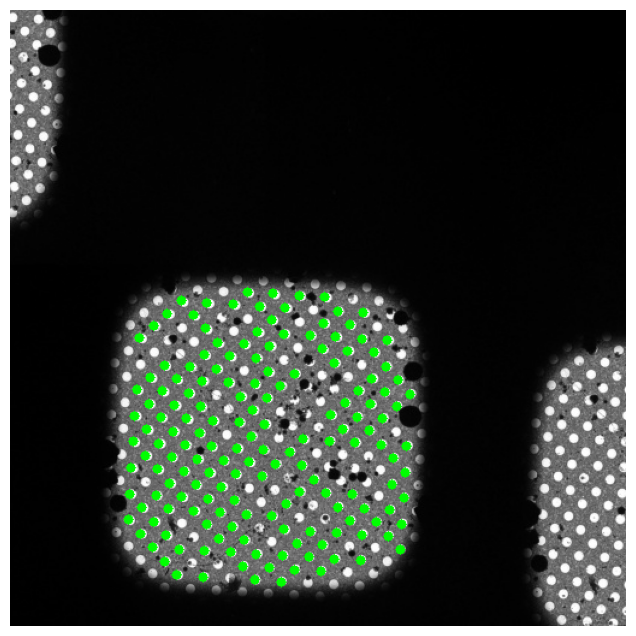

In [70]:

img = img_t12.copy()
img_draw = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

outer_mask = np.ones_like(img, dtype=np.uint8) * 255
cv2.fillPoly(outer_mask, pts=valid_contours, color=0)

inner_mask = np.zeros_like(img, dtype=np.uint8) * 255
cv2.fillPoly(inner_mask, pts=inner_contours, color=255)

good_holes = {
    'coord': [],
    'index': [],
}
for point, indexs in zip(all_points, all_indices):
    m = np.zeros_like(img, dtype=np.uint8)
    cv2.circle(m, center=(int(point[0]), int(point[1])), radius=4, color=(255,255,255), thickness=-1)

    overlap_outer = cv2.bitwise_and(m, outer_mask)
    overlap_inner = cv2.bitwise_and(m, inner_mask)
    
    point_within_bounds = (point[0] > 0 and point[0] < img.shape[1] and point[1] > 0 and point[1] < img.shape[0])
    
    if not np.any(overlap_outer) and not np.any(overlap_inner) and point_within_bounds:
        cv2.circle(img_draw, center=(int(point[0]), int(point[1])), radius=4, color=(0,255,0), thickness=-1)
        good_holes['coord'].append(point)
        good_holes['index'].append(indexs)
    
sizex = int(np.max(all_indices[:,0]) + 1)
sizey = int(np.max(all_indices[:,1]) + 1)

arr = np.zeros((sizex, sizey), dtype=int)
for indexs in good_holes['index']:
    arr[indexs[0], indexs[1]] = 1

print(arr)

display_image(img_draw)

In [71]:
# Array containing detected holes
arr
# Imaging footprint size
footprint_size = 5

#footrpint
footprint = np.ones((footprint_size, footprint_size), dtype=int)

def sum_on_points(values):
    center = len(values) // 2
    if values[center] == 1:
        return np.sum(values)
    else:
        return 0

from scipy.ndimage import generic_filter
filtered_arr = generic_filter(arr, function=sum_on_points, footprint=footprint, mode='constant', cval=0)    

data = []
for i, row in enumerate(filtered_arr):
    for j, val in enumerate(row):
        if val > 0:
            data.append({'row': i, 'column': j, 'value': val})
df = pd.DataFrame(data).sort_values(by=['value'], ascending=False, ignore_index=True)

df['random'] = np.random.randint(100, size=len(df))

df.sort_values(by=['value', 'random'], ascending=[False, False], ignore_index=True, inplace=True)

footprint_locations = []

print(df)

while not df.empty:
    choice = df.iloc[0]

    footprint_locations.append((choice['row'], choice['column']))

    # remove points within footprint of chosen point and that would overlap with it
    def remove_footprint(df, center, size):
        half_size = (size - 1)
        
        x_start = center[0] - half_size
        x_end = center[0] + half_size
        
        y_start = center[1] - half_size
        y_end = center[1] + half_size
        
        # Filter out points within the footprint
        df = df[~((df['row'] >= x_start) & (df['row'] <= x_end) & 
                  (df['column'] >= y_start) & (df['column'] <= y_end))]
        return df

    df = remove_footprint(df, (choice['row'], choice['column']), footprint_size)
    


     row  column  value  random
0      6      12     24      66
1      7      12     24      37
2      8      12     23      80
3      5      12     23      60
4      6      13     23      55
..   ...     ...    ...     ...
162   18       7      8      35
163    0       9      8       5
164    0       7      7      58
165   11      17      7       2
166    0      10      6      94

[167 rows x 4 columns]


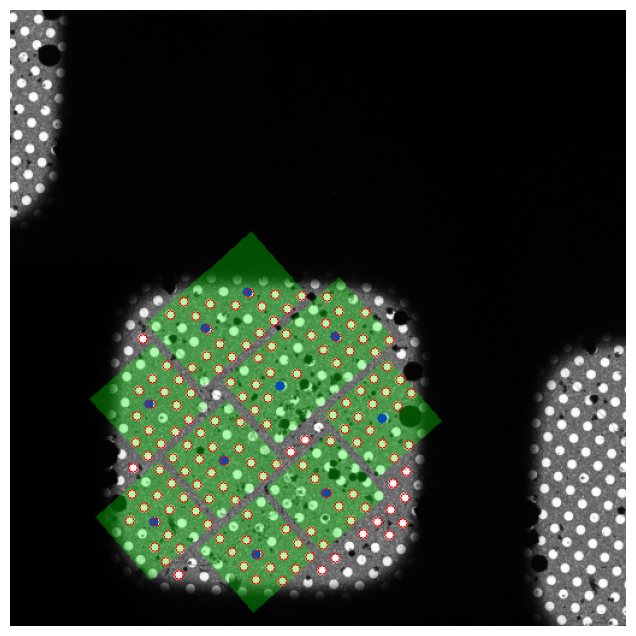

In [82]:
img = img_t12.copy()
img_draw = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

overlay = img_draw.copy()


img_good_holes = np.zeros(img_t12.shape, dtype=np.uint8)
for point in points:
    x = int(round(point[0]))
    y = int(round(point[1]))
    img_good_holes[y, x] = 255

def find_point_good_holes(good_holes, index):
    for i, idx in enumerate(good_holes['index']):
        if (idx == index).all():
            return good_holes['coord'][i]
    return None

import pickle

with open('coords_genome.pkl', 'rb') as f:
    footprint_locations = pickle.load(f)

for i, loc in enumerate(footprint_locations):
    point = find_point_good_holes(good_holes, loc)
    if point is not None:
        if point[0] > img.shape[1] or point[1] > img.shape[0]:
            print(f"Point {point} is out of image bounds, skipping.")
            continue
        
        vertices = np.array([
            [int(point[0] - footprint_size//2 * spacing - 4), int(point[1] - footprint_size//2 * spacing - 4)],
            [int(point[0] + footprint_size//2 * spacing + 4), int(point[1] - footprint_size//2 * spacing - 4)],
            [int(point[0] + footprint_size//2 * spacing + 4), int(point[1] + footprint_size//2 * spacing + 4)],
            [int(point[0] - footprint_size//2 * spacing - 4), int(point[1] + footprint_size//2 * spacing + 4)],
        ])
        for j, v in enumerate(vertices):
            v_shifted = v - point
            v_rotated = rot_matrix @ v_shifted
            vertices[j] = (v_rotated + point).astype(int)
        
        # Count good points within the footprint
        mask = np.zeros_like(img, dtype=np.uint8)
        cv2.fillPoly(mask, [vertices], color=255)
        
        masked_holes = cv2.bitwise_and(img_good_holes, mask)
        n_holes = cv2.countNonZero(masked_holes)
        
        if n_holes < np.sum(footprint) * 0.5:
            continue
        
        cv2.circle(img_draw, center=(int(point[0]), int(point[1])), radius=4, color=(0,0,255), thickness=-1)
        cv2.fillPoly(overlay, [vertices], color=(0,255,0))

alpha = 0.3
img_draw = cv2.addWeighted(overlay, alpha, img_draw, 1 - alpha, 0)
for loc in good_holes['index']:
    point = get_coords_at_index(summary, loc)
    if point:
        point = np.array(point)
        cv2.circle(img_draw, center=(int(point[0]), int(point[1])), radius=4, color=(255,0,0), thickness=1)
        
        
display_image(img_draw)

In [73]:
import pickle

with open('arr.pkl', 'wb') as f:
    pickle.dump(arr, f)
